In [1]:
import numpy as np
import pandas as pd
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
from datetime import datetime
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

%matplotlib inline
warnings.simplefilter('ignore')
sns.set()

In [2]:
def km_per_year(row):
    if row['mileage'] != 0:
        # обрабатываем случаи, когда мошина произведена в год сбора данных, чтоб не делить на 0
        if row['productionDate'] == 2021:
            return row['mileage']
        else:
            return row['mileage']/(2021 - row['productionDate'])
    return 0  # возвращаем 0, если машина без пробега (новая)

def km_per_year_test(row):
    if row['mileage'] != 0:
        # обрабатываем случаи, когда мошина произведена в год сбора данных, чтоб не делить на 0
        if row['productionDate'] == 2020:
            return row['mileage']
        else:
            return row['mileage']/(2020 - row['productionDate'])
    return 0  # возвращаем 0, если машина без пробега (новая)

In [3]:
# Функция перевеодит формат данных "y yyy км" в количество км.

def num_of_km(row):
    if pd.notnull(row):
        list_km = row.split(' ')
        if len(list_km) == 2: 
            if list_km[1] in ['км']:
                return int(list_km[0])
        return int(list_km[0]+list_km[1])

In [4]:
def break_long_names(names):
    len_name = 12
    short_names = []
    for name in names:
        if type(name) != type('') or len(name) < len_name:
            short_names.append(name)
        else:
            short_names.append(name[:len_name] + '\n' + name[len_name:])
    else:
        return short_names

    
def plot_cat_col_vs_price(data, col, ylim, num_categories=16):
    values = data[col].value_counts().index
    if len(values) > num_categories:
        values = values[:num_categories]
    values = list(values)
    data_curr_categories = data.query(f"{col} in {values}")
    curr_categories = break_long_names(data_curr_categories[col].values)

    plt.figure()
    sns.boxplot(x=curr_categories, y=data_curr_categories['price'])
    ylim = sorted(ylim)
    plt.ylim(ylim[0], ylim[1])
    plt.title(col)
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('price')
    plt.grid()
    plt.show()

In [5]:
def date_from_unix(unix):
    return datetime.utcfromtimestamp(unix).strftime('%d-%m-%Y')

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
RANDOM_SEED = 42

In [7]:
cols_to_oh_encode=[]
cols_to_lab_encode=[]
num_cols=[]
bin_cols=[]
cols_to_del_train=[]
cols_to_del_test=[]

In [8]:
# подсчет количества выбросов

def outliers(column): 
    Q1 = column.quantile(0.25)
    Q2 = column.quantile(0.75)
    IQR = Q2 - Q1
    left = Q1 - 1.5 * IQR
    right = Q2 + 1.5 * IQR
    return (column < left).sum() + (column > right).sum(), left, right

In [9]:
dir_train= '../input/parsing-auto-ru-01-12-2021/'
dir_test = '../input/sf-dst-car-price-prediction/'

In [127]:
#!ls '../input'

In [11]:
data_train = pd.read_csv(r'C:\Users\User\projects\Skillfactory\full_data_auto.csv')
data_test = pd.read_csv(r'C:\Users\User\projects\Skillfactory\module_6\test.csv')
#data_train = pd.read_csv(dir_train+'full_data_auto.csv')
#data_test = pd.read_csv(dir_test+'test.csv')

In [12]:
data_train.head()

,model,url,price,doors_amount,model_year,parsing_unixtime,год выпуска,Пробег,Кузов,Цвет,...,Госномер,Обмен,Кузов №,Запас хода,Статус,fuel_type,enginePower,engineVolume,brand,modelDate
0,Skoda Kodiaq I,https://auto.ru/cars/used/sale/skoda/kodiaq/11...,2 400 000 ₽,5.0,I 2016 – н.в.,1638365394,2019,20 000 км,внедорожник 5 дв.,белый,...,******|126,NaN,NaN,NaN,NaN,Бензин,150 л.с.,1.4 л,Skoda,2016.0
1,Skoda Rapid II,https://auto.ru/cars/used/sale/skoda/rapid/110...,1 525 000 ₽,5.0,II 2020 – н.в.,1638365396,2020,18 890 км,лифтбек,синий,...,NaN,Рассмотрю варианты,NaN,NaN,NaN,Бензин,110 л.с.,1.6 л,Skoda,2020.0
2,Skoda Superb II,https://auto.ru/cars/used/sale/skoda/superb/11...,1 450 000 ₽,5.0,II 2008 – 2013,1638365399,2012,119 730 км,универсал 5 дв.,пурпурный,...,******|197,NaN,NaN,NaN,NaN,Дизель,140 л.с.,2.0 л,Skoda,2008.0
3,Skoda Superb II,https://auto.ru/cars/used/sale/skoda/superb/11...,690 000 ₽,5.0,II 2008 – 2013,1638365402,2011,210 000 км,лифтбек,чёрный,...,******|190,NaN,NaN,NaN,NaN,Бензин,152 л.с.,1.8 л,Skoda,2008.0
4,Skoda Octavia I (A4) Рестайлинг,https://auto.ru/cars/used/sale/skoda/octavia/1...,215 000 ₽,5.0,I (A4) Рестайлинг 2000 – 2011,1638365404,2000,183 800 км,лифтбек,зелёный,...,******|198,NaN,NaN,NaN,NaN,Бензин,150 л.с.,1.8 л,Skoda,2000.0


In [13]:
data_test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [14]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40510 entries, 0 to 40509
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   model             40510 non-null  object 
 1   url               40510 non-null  object 
 2   price             40510 non-null  object 
 3   doors_amount      40500 non-null  float64
 4   model_year        40500 non-null  object 
 5   parsing_unixtime  40510 non-null  int64  
 6   год выпуска       40510 non-null  int64  
 7   Пробег            40510 non-null  object 
 8   Кузов             40510 non-null  object 
 9   Цвет              40510 non-null  object 
 10  Двигатель         40510 non-null  object 
 11  Комплектация      32694 non-null  object 
 12  Налог             39588 non-null  object 
 13  Коробка           40510 non-null  object 
 14  Привод            40510 non-null  object 
 15  Руль              40510 non-null  object 
 16  Состояние         40510 non-null  object

In [15]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [16]:
data_train = data_train.rename(columns={'fuel_type': 'fuelType', 'url': 'car_url', 
                                        'doors_amount': 'numberOfDoors', 'Кузов': 'bodyType',
                                        'Цвет': 'color', 'engineVolume': 'engineDisplacement',
                                        'Пробег': 'mileage', 'год выпуска': 'productionDate', 
                                        'Коробка': 'vehicleTransmission'})

In [17]:
# Создадим список с колонками, которые присутствуют и в train, и в test

cols_intersection = list(set(data_test.columns).intersection(data_train.columns))

In [18]:
# Проверим, в каких колонках типы данных различаются у train и test

cols_type_dif = []  
print("Найдены расхождения в типах данных для:")

for col in cols_intersection:
    if type(data_test[col][0]) != type(data_train[col][0]):
        print(
            f"\t- колонки {col}: для train - {type(data_train[col][0])}, для test - {type(data_test[col][0])}")
        cols_type_dif.append(col)

Найдены расхождения в типах данных для:
	- колонки modelDate: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки numberOfDoors: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки mileage: для train - <class 'str'>, для test - <class 'numpy.int64'>
	- колонки Владение: для train - <class 'str'>, для test - <class 'float'>


In [19]:
print("Пример значения для train", data_train['modelDate'].sample(1).values)
print("Пример значения для test", data_test['modelDate'].sample(1).values)

Пример значения для train [2010.]
Пример значения для test [2006]


In [20]:
data_train['modelDate']=data_train['modelDate'].astype('Int64')

In [21]:
print("Пример значения для train", data_train['mileage'].sample(1).values)
print("Пример значения для test", data_test['mileage'].sample(1).values)

Пример значения для train ['324 650 км']
Пример значения для test [273000]


In [22]:
data_train['mileage'] = data_train['mileage'].apply(num_of_km)

In [23]:
print("Пример значения для train", data_train['numberOfDoors'].sample(1).values)
print("Пример значения для test", data_test['numberOfDoors'].sample(1).values)

Пример значения для train [5.]
Пример значения для test [5]


In [24]:
data_train['numberOfDoors']=data_train['numberOfDoors'].astype('Int64')

In [25]:
# Удалим колонку Владение, потому что в ней очень много пропусков и по смыслу коррелируется информация из Пробега и Дате Выпуска. 

In [26]:
cols_to_del_train.append('Владение')
cols_to_del_test.append('Владение')

In [27]:
cols_intersection

['Таможня',
 'Привод',
 'car_url',
 'modelDate',
 'numberOfDoors',
 'parsing_unixtime',
 'brand',
 'ПТС',
 'mileage',
 'enginePower',
 'color',
 'Руль',
 'Состояние',
 'Владельцы',
 'Владение',
 'fuelType',
 'bodyType',
 'engineDisplacement',
 'vehicleTransmission',
 'productionDate']

# Начнем обработку признаков с цены, а следом с общих признаков в датасетах

# Price

In [28]:
data_train['price'].sample(3)

15005      675 000 ₽
6349     3 630 000 ₽
29745      465 000 ₽
Name: price, dtype: object

In [29]:
data_train['price'] = data_train['price'].str.replace(' ', '')
data_train['price']=data_train['price'].str.replace('₽', '')
data_train = data_train[data_train['price'] != 'sold']
data_train['price']=data_train.price.astype(float).astype('Int64')

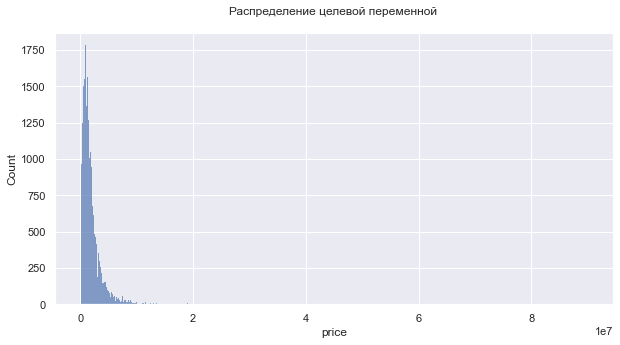

In [30]:
# Посмотрим на распределение целевой переменной
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data_train, x='price')
plt.title("Распределение целевой переменной \n")
plt.show()

In [31]:
outliers(data_train.price)

(2588, -1570500.0, 4617500.0)

In [32]:
# Посмотрим, какие машины имеют особо высокие цены
data_train[(data_train.price > 4617500.0)].groupby(['brand'])['price'].agg(['count', 'max'])

,count,max
brand,,
Audi,319,20000000
BMW,569,90000000
Honda,1,5000001
Infiniti,48,8500000
Lexus,436,23300000
Mercedes-Benz,842,80000000
Mitsubishi,2,7000000
Nissan,3,6999999
Toyota,242,14900000


Eсть очень дорогие авто, которые представлены и в тестовой выборке. Похоже, что эти бренды могут быть экстренно дорогие. Оставим как есть, можно в будещем попробовать удалить автомобилии с большой ценой, где количество таких автомобилей внутри бренда меньше 10.

<AxesSubplot:>

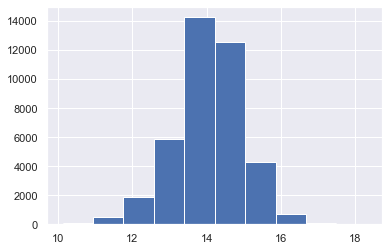

In [33]:
# Распределение цены с очень сильным правым хвостом, посмотрим на признак взяв логорифм от цены

np.log(data_train['price'] + 1).hist()

In [34]:
#Распределение стало намного нормальнее. Отправим признак на стандартизацию

num_cols.append('price')

# Владельцы

In [35]:
print("Значения в train", data_train['Владельцы'].unique())
print("Значения в test", data_test['Владельцы'].unique())

Значения в train ['1 владелец' '3 или более' '2 владельца' nan]
Значения в test ['3 или более' '1\xa0владелец' '2\xa0владельца']


In [36]:
# Удаояем 1 строку с пропуском

data_train.dropna(subset=['Владельцы'], inplace=True)

In [37]:
ownersCount_dict = {'3 или более': 3,
                    '1\xa0владелец': 1,
                    '2\xa0владельца': 2,
                    '1 владелец': 1, 
                    '2 владельца': 2, 
                    '3 или более': 3}

In [38]:
data_test['Владельцы'].replace(
    to_replace=ownersCount_dict, inplace=True)

data_train['Владельцы'].replace(
    to_replace=ownersCount_dict, inplace=True)

In [39]:
print("Значения в train", data_train['Владельцы'].unique())
print("Значения в test", data_test['Владельцы'].unique())

Значения в train [1 3 2]
Значения в test [3 1 2]


In [40]:
data_train['Владельцы']=data_train['Владельцы'].astype('Int64')
data_test['Владельцы']=data_test['Владельцы'].astype('Int64')

In [41]:
print("Значения в train", data_train['Владельцы'].unique())
print("Значения в test", data_test['Владельцы'].unique())

Значения в train <IntegerArray>
[1, 3, 2]
Length: 3, dtype: Int64
Значения в test <IntegerArray>
[3, 1, 2]
Length: 3, dtype: Int64


In [44]:
data_train['Владельцы']=data_train['Владельцы'].astype(float)

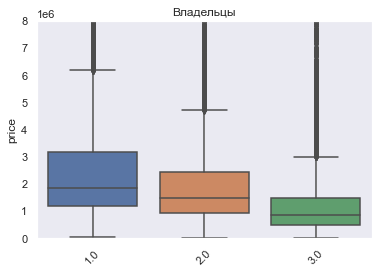

In [45]:
plot_cat_col_vs_price(data_train, 'Владельцы', [0, 8e6])

In [46]:
data_train['Владельцы']=data_train['Владельцы'].astype('Int64')

In [47]:
data_train['Владельцы'].unique()

<IntegerArray>
[1, 3, 2]
Length: 3, dtype: Int64

Логично, что чем меньше владельцев было у машины, тем она младще и тем дороже. 

In [43]:
cols_to_oh_encode.append('Владельцы')

# Car_url

In [48]:
print("Пример значения для train", data_train['car_url'].unique())
print("Пример значения для test", data_test['car_url'].unique())

Пример значения для train ['https://auto.ru/cars/used/sale/skoda/kodiaq/1106065854-e0e3e9d6/'
 'https://auto.ru/cars/used/sale/skoda/rapid/1106020729-f640cb08/'
 'https://auto.ru/cars/used/sale/skoda/superb/1105137525-90afda78/' ...
 'https://auto.ru/cars/used/sale/audi/q7/1106021243-aa185d05/'
 'https://auto.ru/cars/used/sale/audi/a6/1105732285-1e849b1b/'
 'https://auto.ru/cars/used/sale/audi/a7/1104871984-d57282d9/']
Пример значения для test ['https://auto.ru/cars/used/sale/skoda/octavia/1100575026-c780dc09/'
 'https://auto.ru/cars/used/sale/skoda/octavia/1100549428-595cadf2/'
 'https://auto.ru/cars/used/sale/skoda/superb/1100658222-7ac3def5/' ...
 'https://auto.ru/cars/used/sale/bmw/5er/1101364889-0c6be825/'
 'https://auto.ru/cars/used/sale/bmw/x1/1101362518-34628283/'
 'https://auto.ru/cars/used/sale/bmw/x5/1101256068-ed03accb/']


Отправляем признак в очередь на удаление

In [49]:
cols_to_del_train.append('car_url')
cols_to_del_test.append('car_url')

# Руль

In [50]:
print("Значения в train", data_train['Руль'].unique())
print("Значения в test", data_test['Руль'].unique())

Значения в train ['Левый' 'Правый']
Значения в test ['Левый' 'Правый']


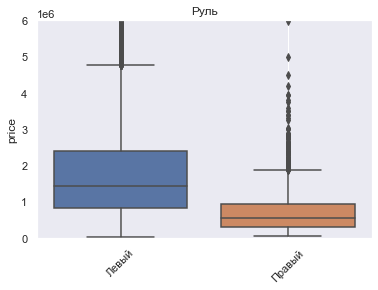

In [51]:
plot_cat_col_vs_price(data_train, 'Руль', [0, 6e6])

In [52]:
cols_to_oh_encode.append('Руль')

# FuelType

In [53]:
print("Статистика значений для train\n", data_train['fuelType'].value_counts())
print("Статистика значений для test\n", data_test['fuelType'].value_counts())

Статистика значений для train
 Бензин                                32514
Дизель                                 6426
Гибрид                                  858
Бензин, газобаллонное оборудование      421
Электро                                  84
Газ, газобаллонное оборудование           1
Гибрид, газобаллонное оборудование        1
Дизель, газобаллонное оборудование        1
Газ                                       1
Name: fuelType, dtype: int64
Статистика значений для test
 бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64


In [54]:
data_train['fuelType'] = data_train.fuelType.apply(lambda x: 'бензин' if x=='Бензин' 
                                                    else 'дизель' if x =='Дизель'
                                                    else 'гибрид' if x == 'Гибрид' 
                                                    else 'электро' if x== 'Электро'
                                                    else 'газ')

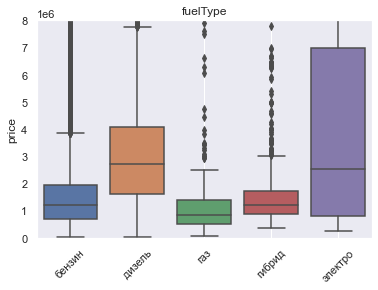

In [55]:
plot_cat_col_vs_price(data_train, 'fuelType', [0, 8e6])

In [56]:
cols_to_lab_encode.append('fuelType')

# Parsing_unixtime

In [57]:
print("Статистика значений для train\n", data_train['parsing_unixtime'].value_counts())
print("Статистика значений для test\n", data_test['parsing_unixtime'].value_counts())

Статистика значений для train
 1638365394    1
1638679392    1
1638679370    1
1638679373    1
1638679376    1
             ..
1638475421    1
1638475425    1
1638475429    1
1638475433    1
1639131491    1
Name: parsing_unixtime, Length: 40307, dtype: int64
Статистика значений для test
 1603226273    1
1603301936    1
1603301988    1
1603301984    1
1603301980    1
             ..
1603271287    1
1603271277    1
1603271273    1
1603271270    1
1603710264    1
Name: parsing_unixtime, Length: 34686, dtype: int64


Parsing_unixtime - время и дата публикации в формате unixtime. Получим дату в понятном виде и удалим признак т.к. нам ничем он не будет полезен. 

In [58]:
cols_to_del_train.append('parsing_unixtime')
cols_to_del_test.append('parsing_unixtime')

In [59]:
data_train['parsing_date'] = data_train['parsing_unixtime'].apply(date_from_unix)

In [60]:
data_test['parsing_date'] = data_test['parsing_unixtime'].apply(date_from_unix)

Пользуясь датой сбора информации в двух датасетах, вычислим примерную стоимость авто в трейне в долларах. Может быть цена в долларах будет более информативна на промежутке в 1 год.

In [61]:
print(data_train['parsing_date'].unique())
print(data_test['parsing_date'].unique())

['01-12-2021' '02-12-2021' '03-12-2021' '04-12-2021' '05-12-2021'
 '06-12-2021' '10-12-2021']
['20-10-2020' '19-10-2020' '21-10-2020' '24-10-2020' '25-10-2020'
 '26-10-2020']


In [62]:
usd_cur_dict = {'19-10-2020': 77.96, '20-10-2020': 77.92, '21-10-2020': 77.78, '24-10-2020': 76.47, '25-10-2020': 76.47,
               '26-10-2020': 76.47, '01-12-2021': 73.97, '02-12-2021': 74.06, '03-12-2021': 73.74, '04-12-2021': 73.74, 
                '05-12-2021': 73.74, '06-12-2021': 73.67, '10-12-2021': 73.61}
mean_currency_dict = {2020: 77.8, 2021: 73.8}

In [63]:
data_train['usd_currency'] = data_train['parsing_date'].apply(lambda x: usd_cur_dict[x])
data_test['usd_currency'] = data_test['parsing_date'].apply(lambda x: usd_cur_dict[x])
data_train['price_usd'] = data_train['price']/data_train['usd_currency']

# ProductionDate

In [64]:
print("Значения в train", data_train['productionDate'].unique())
print("Значения в test", data_test['productionDate'].unique())

Значения в train [2019 2020 2012 2011 2000 1998 2015 2017 2007 2013 2014 2016 2001 2008
 2010 2018 2021 2006 2005 2009 2003 1994 2002 1997 1996 1999 2004 1987
 1989 1993 1991 1990 1959 1992 1988 1995 1986 1984 1985 1982 1978 1974
 1979 1981 1968 1980 1983 1948 1939 1975 1976 1960 1971]
Значения в test [2014 2017 2012 2011 2019 2018 2010 2020 2016 2013 2006 2007 2015 2005
 2008 2009 1997 2004 2002 1987 2003 2001 1976 2000 1998 1995 1999 1993
 1939 1996 1984 1990 1991 1992 1989 1982 1985 1994 1938 1981 1988 1983
 1980 1986 1978 1970 1979 1977 1972 1975 1969 1950 1953 1949 1937 1959
 1968 1936 1904 1974 1967 1961 1960 1965 1963 1957 1952 1973 1948]


In [65]:
print("Минимальное значение в train", data_train['productionDate'].min())
print("Минимальное значение в test", data_test['productionDate'].min())
print("Максимальное значение в train", data_train['productionDate'].max())
print("Максимальное значение в test", data_test['productionDate'].max())

Минимальное значение в train 1939
Минимальное значение в test 1904
Максимальное значение в train 2021
Максимальное значение в test 2020


Не будем искать и удалять выбросы, так как в тесте тоже есть старые автомобили, цену на которые надо предсказать

<AxesSubplot:>

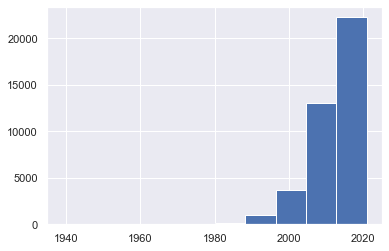

In [66]:
data_train['productionDate'].hist()

<AxesSubplot:>

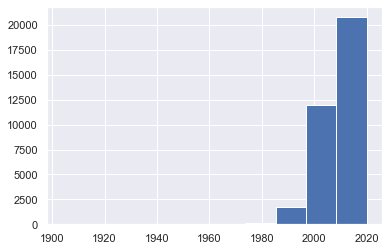

In [67]:
data_test['productionDate'].hist()

Посмотрим как будет выглядеть логарифмированный признак

<AxesSubplot:>

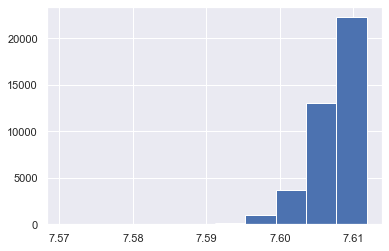

In [68]:
np.log(data_train['productionDate'] + 1).hist()

Особо не изменился. Отправляем на стандартизацию

Еще есть идея создать признак с возрастом машины, т.к. в тесте и трейне данные собраны с разницей в один год, информативнее будет смотреть на возраст машины в момент создания датасета

In [69]:
data_train['carAge'] = 2021 - data_train['productionDate']
data_test['carAge'] = 2020 - data_test['productionDate']

In [70]:
num_cols.append('carAge')
num_cols.append('productionDate')

# BodyType

In [71]:
print("Статистика значений для train\n", data_train['bodyType'].value_counts())
print("Статистика значений для test\n", data_test['bodyType'].value_counts())

Статистика значений для train
 внедорожник 5 дв.          18357
седан                      11846
лифтбек                     3035
хэтчбек 5 дв.               2463
универсал 5 дв.             1204
минивэн                      955
купе                         713
компактвэн                   678
хэтчбек 3 дв.                313
пикап двойная кабина         308
кабриолет                    105
внедорожник 3 дв.            101
купе-хардтоп                  89
родстер                       54
микровэн                      34
фургон                        30
седан-хардтоп                  7
седан 2 дв.                    4
пикап полуторная кабина        4
пикап одинарная кабина         3
лимузин                        3
внедорожник открытый           1
Name: bodyType, dtype: int64
Статистика значений для test
 седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн            

In [72]:
data_train['bodyType'].replace(regex={r'внедорожник.*': 'внедорожник',
                                r'седан.*': 'седан',
                                r'хэтчбек.*': 'хэтчбек',
                                r'купе.*': 'купе',  r'тарга.*': 'тарга', r'микровэн.*': 'микровэн',
                                r'пикап.*': 'пикап', r'родстер.*': 'родстер',
                                r'универсал.*': 'универсал', r'лифтбек.*': 'лифтбек',
                                r'минивэн.*': 'минивэн', r'компактвэн.*': 'компактвэн',
                                r'лимузин.*': 'лимузин', r'фургон.*': 'фургон', r'кабриолет.*': 'кабриолет'
                                },
                         inplace=True)

In [73]:
data_test['bodyType'].replace(regex={r'внедорожник.*': 'внедорожник',
                                r'седан.*': 'седан',
                                r'хэтчбек.*': 'хэтчбек',
                                r'купе.*': 'купе',  r'тарга.*': 'тарга', r'микровэн.*': 'микровэн',
                                r'пикап.*': 'пикап', r'родстер.*': 'родстер',
                                r'универсал.*': 'универсал', r'лифтбек.*': 'лифтбек',
                                r'минивэн.*': 'минивэн', r'компактвэн.*': 'компактвэн',
                                r'лимузин.*': 'лимузин', r'фургон.*': 'фургон', r'кабриолет.*': 'кабриолет'
                                },
                         inplace=True)

In [74]:
print("Статистика значений для train\n", data_train['bodyType'].value_counts())
print("Статистика значений для test\n", data_test['bodyType'].value_counts())

Статистика значений для train
 внедорожник    18459
седан          11857
лифтбек         3035
хэтчбек         2776
универсал       1204
минивэн          955
купе             802
компактвэн       678
пикап            315
кабриолет        105
родстер           54
микровэн          34
фургон            30
лимузин            3
Name: bodyType, dtype: int64
Статистика значений для test
 седан          13165
внедорожник    12346
хэтчбек         2609
лифтбек         2232
универсал       1276
минивэн          995
купе             982
компактвэн       489
пикап            290
родстер           99
фургон            97
кабриолет         90
микровэн           7
лимузин            6
тарга              2
фастбек            1
Name: bodyType, dtype: int64


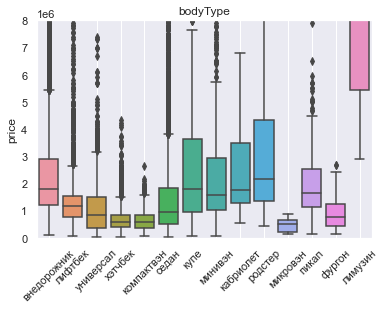

In [75]:
plot_cat_col_vs_price(data_train, 'bodyType', [0, 8e6])

Предлагаю топ 8 типов автомобилей по дороговизне и оформить как отдельный признак

In [76]:
expensive_bodyType=['внедорожник', 'купе', 'микровэн', 'кабриолет', 'родстер', 'пикап', 'лимузин']

In [77]:
data_test['expensive_bodyType']=data_test['bodyType'].apply(lambda x: 1 if x in expensive_bodyType
                                                            else 0)
data_train['expensive_bodyType']=data_train['bodyType'].apply(lambda x: 1 if x in expensive_bodyType
                                                            else 0)

In [78]:
cols_to_lab_encode.append('bodyType')
bin_cols.append('expensive_bodyType')

# Color

In [79]:
print("Статистика значений для train\n", data_train['color'].value_counts())
print("Статистика значений для test\n", data_test['color'].value_counts())

Статистика значений для train
 чёрный         11549
белый           9352
серый           5585
серебристый     3782
синий           3442
коричневый      1895
красный         1874
бежевый          737
зелёный          719
голубой          411
пурпурный        235
золотистый       233
фиолетовый       197
оранжевый        165
жёлтый           123
розовый            8
Name: color, dtype: int64
Статистика значений для test
 чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64


Сделаем новый признак, который будет показывать популярного ли цвета машина. Возмем за популярные цвета: чёрный, белый, 
серебристый, серый, синий, красный и коричневый, так как после них виден явный перепад в кол-ве автомобилей. А признак color удалить. 

In [80]:
data_train['popular_color'] = data_train['color'].apply(lambda x: 1 if x in ['чёрный', 'белый', 
                                                                 'серебристый', 'серый',
                                                                 'синий', 'красный', 'коричневый'] 
                                                    else 0)

In [81]:
data_test['popular_color'] = data_test['color'].apply(lambda x: 1 if x in ['чёрный', 'белый', 
                                                                 'серебристый', 'серый',
                                                                 'синий', 'красный', 'коричневый'] 
                                                    else 0)

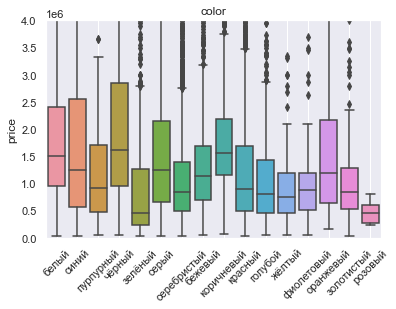

In [82]:
plot_cat_col_vs_price(data_train, 'color', [0, 4e6])

Видим, что популярные цвета обычно и дороже. 

In [83]:
cols_to_del_train.append('color')
cols_to_del_test.append('color')
bin_cols.append('popular_color')

# ModelDate

In [84]:
print("Значения в train", data_train['modelDate'].unique())
print("Значения в test", data_test['modelDate'].unique())

Значения в train <IntegerArray>
[2016, 2020, 2008, 2000, 1996, 2013, 2017, 2019, 2015, 1999, 2006, 2009, 2007,
 2012, 2010, 2004, 1990, 2001, 1994, 2005, 1998, 2011, 1991, 1993, 1997, 1983,
 1995, 1987, 2002, 2018, 2014, 2003, 1988, 1958, 2021, 1982, 1992, 1989, <NA>,
 1985, 1981, 1979, 1974, 1968, 1975, 1937, 1986, 1976, 1977, 1978, 1957, 1984,
 1971, 1955, 1980, 1967]
Length: 56, dtype: Int64
Значения в test [2013 2017 2008 2009 2016 2012 2015 2010 2006 2000 2007 1994 2004 1999
 2005 1976 2001 1969 1996 1998 1989 1934 2014 2011 2018 1986 1997 1990
 2019 2002 1991 1987 1980 1982 1938 1988 2003 1983 1978 1979 1984 1992
 1995 1993 1985 1974 1966 1977 1981 1972 1968 1975 1949 1937 1936 1973
 1959 1958 2020 1965 1971 1904 1963 1955 1951 1960]


In [85]:
data_test['modelDate'] = data_test['modelDate'].astype('Int64')

Получим еще признак, показывающий насколько новая модель была в производстве. Т.к. иногда в первых версиях модельного ряда бывают недочеты, которые со временем исправляются в последующих версиях данной модели.

In [86]:
data_train['modelAge'] = data_train['productionDate'] - data_train['modelDate']
data_test['modelAge'] = data_test['productionDate'] - data_test['modelDate']

Оставим этот признак, как и ProductionDate, позже возможно придется выбрать по значимости какой-то один

<AxesSubplot:>

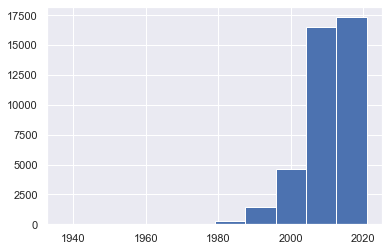

In [87]:
data_train['modelDate'].hist()

<AxesSubplot:>

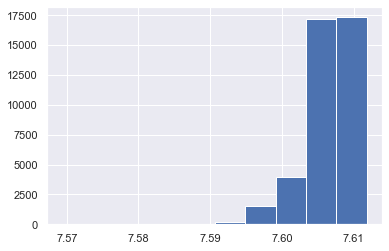

In [88]:
np.log(data_train['modelDate'] + 1).hist()

In [89]:
num_cols.append('modelDate')
num_cols.append('modelAge')

# Таможня

In [90]:
print("Значения в train", data_train['Таможня'].unique())
print("Значения в test", data_test['Таможня'].unique())

Значения в train ['Растаможен']
Значения в test ['Растаможен']


Удаляем признак, так как все автомобили растаможены, но в будущем для модели нужно обращать внимание не появились ли не растаможенные автомобили. 

In [91]:
cols_to_del_train.append('Таможня')
cols_to_del_test.append('Таможня')

# Mileage

In [92]:
print("Статистика значений для train\n", data_train['mileage'].value_counts())
print("Статистика значений для test\n", data_test['mileage'].value_counts())

Статистика значений для train
 200000    372
250000    312
300000    301
180000    282
150000    264
         ... 
17727       1
286771      1
105344      1
127305      1
93345       1
Name: mileage, Length: 17001, dtype: int64
Статистика значений для test
 200000    436
150000    382
300000    381
180000    347
250000    346
         ... 
140237      1
121449      1
210311      1
121363      1
157965      1
Name: mileage, Length: 11268, dtype: int64


In [93]:
print("Максимальное значение для train", data_train['mileage'].max())
print("Максимальное значение для test", data_test['mileage'].max())

Максимальное значение для train 999999
Максимальное значение для test 1000000


In [94]:
print("Минимальное значение для train", data_train['mileage'].min())
print("Минимальное значение для test", data_test['mileage'].min())

Минимальное значение для train 1
Минимальное значение для test 1


Так как и в тестовой выборке надо предсказать стоимость автомобиля с большим пробегом, мы опять не будем искать и удалять выбросы. 

<AxesSubplot:>

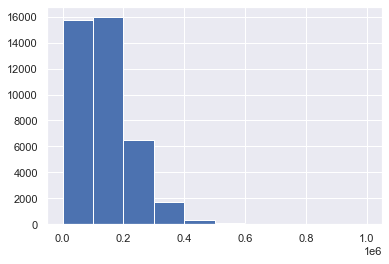

In [95]:
data_train['mileage'].hist()

<AxesSubplot:>

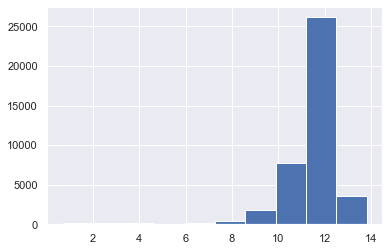

In [96]:
np.log(data_train['mileage'] + 1).hist()

Отправляем на стандартизацию

In [97]:
num_cols.append('mileage')

Еще предлагаю сделать признак который покажет сколько в год пробегала машина, потому что я думаю что есть разница проехала машина Х км за год или 5. 

In [98]:
data_train['km_per_year']=data_train.apply(km_per_year, axis=1)
data_test['km_per_year']=data_test.apply(km_per_year_test, axis=1)

<AxesSubplot:>

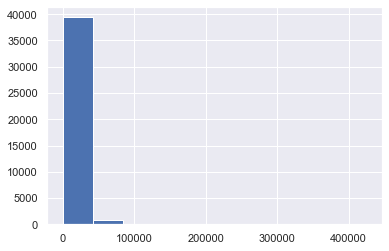

In [99]:
data_train['km_per_year'].hist()

<AxesSubplot:>

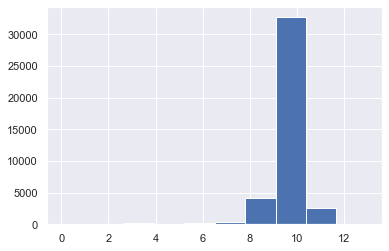

In [100]:
np.log(data_train['km_per_year'] + 1).hist()

In [101]:
num_cols.append('km_per_year')

# NumberOfDoors

In [102]:
print("Статистика значений для train\n", data_train['numberOfDoors'].value_counts())
print("Статистика значений для test\n", data_test['numberOfDoors'].value_counts())

Статистика значений для train
 5    26322
4    12582
2      975
3      418
Name: numberOfDoors, dtype: Int64
Статистика значений для test
 5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64


In [103]:
data_train['numberOfDoors'] = data_train['numberOfDoors'].astype(float)

Автомобиль без двери - возможно это или ошибка или ретро-автомобиль. Ну в любом случае он в тестовой выборке - мы ничего не делаем. 

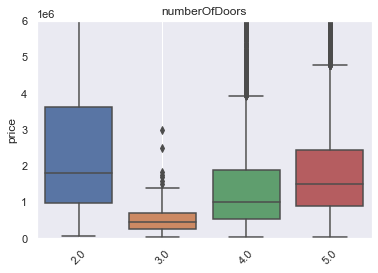

In [104]:
plot_cat_col_vs_price(data_train, 'numberOfDoors', [0, 6e6])

In [105]:
data_train['numberOfDoors'] = data_train['numberOfDoors'].astype('Int64')

Двухдверные машины это обычно спортиные машины, и они дороже. 

In [106]:
cols_to_oh_encode.append('numberOfDoors')

# EngineDisplacement

In [107]:
print("Значения в train", data_train['engineDisplacement'].unique())
print("Значения в test", data_test['engineDisplacement'].unique())

Значения в train ['1.4 л ' '1.6 л ' '2.0 л ' '1.8 л ' '1.2 л ' '3.6 л ' '1.3 л ' '1.5 л '
 '1.9 л ' '3.5 л ' '2.2 л ' '2.3 л ' '2.4 л ' '1.7 л ' '2.5 л ' '3.2 л '
 '4.4 л ' '2.9 л ' '3.0 л ' '2.8 л ' '0.7 л ' '109 л.с. ' '5.6 л '
 '3.7 л ' '4.5 л ' '2.1 л ' '5.5 л ' '4.2 л ' '6.0 л ' '4.0 л ' '4.7 л '
 '5.4 л ' '1.0 л ' '5.7 л ' '2.7 л ' '3.4 л ' '5.0 л ' '4.3 л ' '4.6 л '
 '4.8 л ' '184 л.с. ' '170 л.с. ' '6.6 л ' '3.3 л ' '3.8 л ' '150 л.с. '
 '218 л.с. ' '4.1 л ' '2.6 л ' '333 л.с. ' '408 л.с. ' '6.2 л ' '5.8 л '
 '179 л.с. ' '204 л.с. ' '136 л.с. ' '74 л.с. ' '1.1 л ' '64 л.с. '
 '67 л.с. ' '41 л.с. ' '5.9 л ' '5.2 л ' '503 л.с. ' '3.1 л ' '313 л.с. '
 '6.3 л ']
Значения в test ['1.2 LTR' '1.6 LTR' '1.8 LTR' '2.0 LTR' '1.4 LTR' '1.3 LTR' '1.0 LTR'
 '3.6 LTR' '1.5 LTR' '1.9 LTR' '2.8 LTR' '1.1 LTR' '2.5 LTR' '4.2 LTR'
 '3.0 LTR' '4.0 LTR' '5.9 LTR' '2.7 LTR' '3.1 LTR' '2.4 LTR' '5.2 LTR'
 '3.2 LTR' '4.1 LTR' '6.3 LTR' '2.3 LTR' '6.0 LTR' '2.2 LTR' '3.7 LTR'
 '2.9 LTR' '5.0 LTR' '3.3

In [108]:
data_test[data_test['engineDisplacement']==' LTR'].fuelType.unique()

array(['электро'], dtype=object)

In [109]:
# Для значений 'LTR' заменим на 0, т.к. это электрокары

engineDisplacement_dict = {' LTR':'0.0 LTR'}
                           
data_test['engineDisplacement'].replace(
    to_replace=engineDisplacement_dict, inplace=True)

In [110]:
data_test['engineDisplacement'] = data_test['engineDisplacement'].str.extract(r"(\d\.\d)", expand=True).astype('float')

In [111]:
data_train['engineDisplacement'] = data_train['engineDisplacement'].apply(lambda x: x[:3])

In [112]:
data_train['engineDisplacement'] = data_train['engineDisplacement'].astype('float')

In [113]:
data_train[data_train['engineDisplacement']>10].fuelType.unique()

array(['электро'], dtype=object)

<AxesSubplot:>

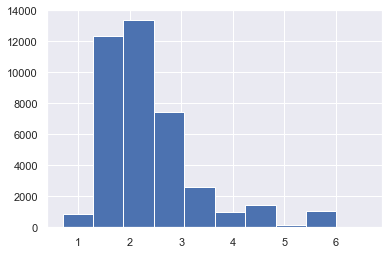

In [114]:
data_train['engineDisplacement'][data_train['engineDisplacement']<10].hist()

<AxesSubplot:>

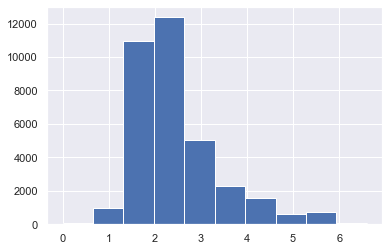

In [115]:
data_test['engineDisplacement'].hist()

In [116]:
# Прировняем значение engineDisplacement для электрокаров к одному виду

data_train['engineDisplacement'][data_train['engineDisplacement']>10]=0.0

In [117]:
num_cols.append('engineDisplacement')

# Привод

In [118]:
print("Значения в train", data_train['Привод'].unique())
print("Значения в test", data_test['Привод'].unique())

Значения в train ['передний' 'полный' 'задний']
Значения в test ['передний' 'полный' 'задний']


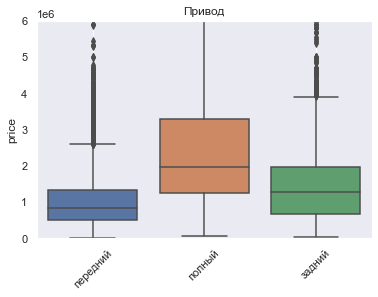

In [119]:
plot_cat_col_vs_price(data_train, 'Привод', [0, 6e6])

In [120]:
cols_to_oh_encode.append('Привод')

# VehicleTransmission

In [121]:
print("Значения в train", data_train['vehicleTransmission'].unique())
print("Значения в test", data_test['vehicleTransmission'].unique())

Значения в train ['роботизированная' 'автоматическая' 'механическая' 'вариатор']
Значения в test ['роботизированная' 'механическая' 'автоматическая' 'вариатор']


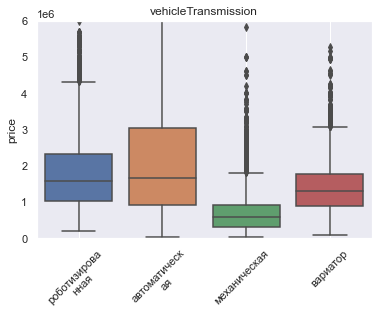

In [122]:
plot_cat_col_vs_price(data_train, 'vehicleTransmission', [0, 6e6])

In [123]:
cols_to_oh_encode.append('vehicleTransmission')

# Brand

In [124]:
print("Значения в train", data_train['brand'].unique())
print("Значения в test", data_test['brand'].unique())

Значения в train ['Skoda' 'Honda' 'Volvo' 'BMW' 'Nissan' 'Infiniti' 'Mercedes-Benz'
 'Toyota' 'Lexus' 'Volkswagen' 'Mitsubishi' 'Audi']
Значения в test ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']


In [125]:
print("Значения в train", data_train['brand'].unique())
print("Значения в test", data_test['brand'].unique())

Значения в train ['Skoda' 'Honda' 'Volvo' 'BMW' 'Nissan' 'Infiniti' 'Mercedes-Benz'
 'Toyota' 'Lexus' 'Volkswagen' 'Mitsubishi' 'Audi']
Значения в test ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']


In [126]:
data_train['brand'] = data_train['brand'].str.lower()
data_test['brand'] = data_test['brand'].str.lower()

In [127]:
data_train['brand'][data_train['brand']=='mercedes-benz']='mercedes'

In [128]:
print("Статистика значений для train\n", data_train['brand'].value_counts())
print("Статистика значений для test\n", data_test['brand'].value_counts())

Статистика значений для train
 honda         3841
skoda         3718
bmw           3663
nissan        3663
mercedes      3663
mitsubishi    3663
toyota        3662
volkswagen    3661
audi          3661
lexus         3164
volvo         2442
infiniti      1506
Name: brand, dtype: int64
Статистика значений для test
 bmw           4473
volkswagen    4404
nissan        4393
mercedes      4180
toyota        3913
audi          3421
mitsubishi    2843
skoda         2741
volvo         1463
honda         1150
infiniti       871
lexus          834
Name: brand, dtype: int64


Какие-то популярные топ брендов не выделяется одинаковый и в train и в test. Отправим признак на кодирование.  

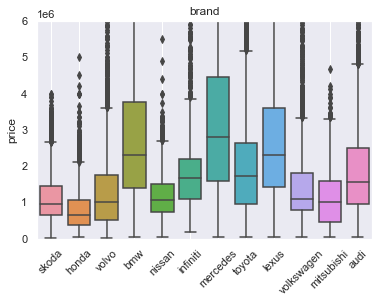

In [129]:
plot_cat_col_vs_price(data_train, 'brand', [0, 6e6])

Предлагаю сделать новый признак о дороговызне машин. 

In [130]:
expensive_brand=['audi', 'bmw', 'infiniti', 'mercedes', 'toyota', 'lexus']

In [131]:
data_test['expensive_brand']=data_test['brand'].apply(lambda x: 1 if x in expensive_brand
                                                            else 0)
data_train['expensive_brand']=data_train['brand'].apply(lambda x: 1 if x in expensive_brand
                                                            else 0)

In [132]:
cols_to_lab_encode.append('brand')
bin_cols.append('expensive_brand')

# Состояние

In [133]:
print("Значения в train", data_train['Состояние'].unique())
print("Значения в test", data_test['Состояние'].unique())

Значения в train ['Не требует ремонта']
Значения в test ['Не требует ремонта']


Удаляю признак, так как он имеет только 1 значение, но в будущем нужно обращать внимание на этот признак, возможно появятся еще значения  

In [134]:
cols_to_del_train.append('Состояние')
cols_to_del_test.append('Состояние')

# EnginePower

In [135]:
print("Пример значения для train", data_train['enginePower'].sample(1).values)
print("Пример значения для test", data_test['enginePower'].sample(1).values)

Пример значения для train [' 190 л.с. ']
Пример значения для test ['136 N12']


In [136]:
# Преобразовываем значения столбца, избавляемся от постфиков л.с. и N12
data_train['enginePower'] = data_train['enginePower'].apply(
    lambda x: int(x.split(" ")[1]))
data_test['enginePower'] = data_test['enginePower'].apply(
    lambda x: int(x.split(" ")[0]))

<AxesSubplot:>

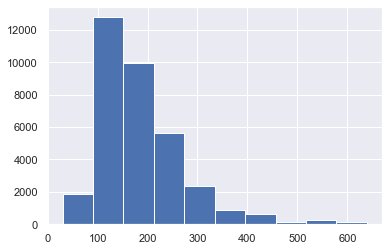

In [137]:
data_test['enginePower'].hist()

<AxesSubplot:>

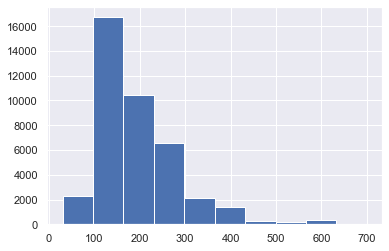

In [138]:
data_train['enginePower'].hist()

Не хороший хвост у графика, посмотрим как будет выглядеть логарифмированный признак

<AxesSubplot:>

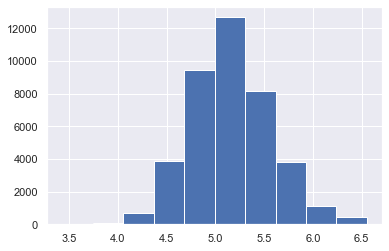

In [139]:
np.log(data_train['enginePower'] + 1).hist()

<AxesSubplot:>

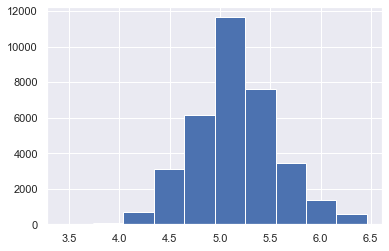

In [140]:
np.log(data_test['enginePower'] + 1).hist()

Так намного лучше! Отправим на стандартизацию

In [141]:
num_cols.append('enginePower')

# ПТС

In [142]:
print("Значения в train", data_train['ПТС'].unique())
print("Значения в test", data_test['ПТС'].unique())

Значения в train ['Оригинал' 'Дубликат']
Значения в test ['Оригинал' 'Дубликат' nan]


In [143]:
print("Заполнено значений в train", data_train['ПТС'].isna().value_counts())
print("Заполнено значений в test", data_test['ПТС'].isna().value_counts())

Заполнено значений в train False    40307
Name: ПТС, dtype: int64
Заполнено значений в test False    34685
True         1
Name: ПТС, dtype: int64


In [144]:
# Пропуск только 1, но он в test, поэтому заменим его на категорию. Выберем 'Дубликат'.

data_test['ПТС']=data_test['ПТС'].fillna('Дубликат')

In [145]:
cols_to_oh_encode.append('ПТС')

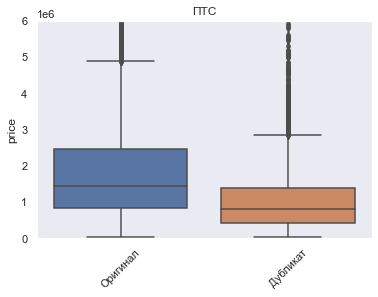

In [146]:
plot_cat_col_vs_price(data_train, 'ПТС', [0, 6e6])

# Обзор признаков, которых нет или в test или в train

In [147]:
# Список колонок, которых нет в test
dif_list_2 = list(set(data_train.columns).difference(data_test.columns))
print("Список колонок, которых нет в test, но есть в train:", dif_list_2)

Список колонок, которых нет в test, но есть в train: ['Госномер', 'Статус', 'Комплектация', 'Гарантия', 'price_usd', 'price', 'Обмен', 'Налог', 'Двигатель', 'Запас хода', 'model_year', 'VIN', 'Кузов №', 'model']


In [148]:
# Посмотрим на данные в этих колонках
data_train[dif_list_2].sample(3)

,Госномер,Статус,Комплектация,Гарантия,price_usd,price,Обмен,Налог,Двигатель,Запас хода,model_year,VIN,Кузов №,model
4754,******|43,NaN,1 опция,NaN,7490.874679,554100,NaN,4 500 ₽ / год,"['2.0 л ', ' 150 л.с. ', ' ,Бензин']",NaN,II 2001 – 2004,SHS**************,NaN,Honda CR-V II
13005,NaN,NaN,19 опций,NaN,13772.616797,1020000,NaN,7 605 ₽ / год,"['2.5 л ', ' 169 л.с. ', ' ,Бензин']",NaN,II Рестайлинг 2010 – 2015,Z8N**************,NaN,Nissan X-Trail II Рестайлинг
32193,NaN,NaN,12 опций,NaN,17629.509086,1300000,Рассмотрю варианты,8 350 ₽ / год,"['2.4 л ', ' 167 л.с. ', ' ,Бензин']",NaN,III 2012 – 2015,Z8T**************,NaN,Mitsubishi Outlander III


In [149]:
print("Значения в train", data_train['Запас хода'].unique())

Значения в train [nan '170 км' '175 км' '64 км' '31 км' '200 км' '203 км' '260 км' '3 км'
 '37 км' '130 км' '270 км' '385 км' '199 км' '250 км' '106 км' '770 км'
 '30 км' '445 км' '417 км' '23 км' '2 км' '50 км' '201 км' '54 км'
 '160 км' '150 км' '436 км' '370 км' '343 км' '347 км' '336 км' '446 км']


In [150]:
print("Значения в train", data_train['Налог'].unique())

Значения в train ['2 175 ₽ / год' '2 750 ₽ / год' '4 900 ₽ / год' ... '25 400 ₽ / год'
 '50 000 ₽ / год' '25 296 ₽ / год']


In [151]:
print("Значения в train", data_train['Гарантия'].unique())

Значения в train ['До мая 2022' nan 'До марта 2023' 'До августа 2022' 'До июня 2023'
 'До октября 2022' 'До октября 2024' 'До мая 2025' 'До ноября 2023'
 'До сентября 2022' 'До сентября 2024' 'До декабря 2022' 'До октября 2023'
 'До июля 2022' 'До декабря 2023' 'До сентября 2023' 'До июня 2025'
 'До июня 2022' 'До марта 2024' 'До апреля 2023' 'До июня 2024'
 'До мая 2024' 'До ноября 2024' 'До ноября 2022' 'До июля 2024'
 'До января 2022' 'До апреля 2024' 'До декабря 2021' 'До апреля 2025'
 'До января 2024' 'До августа 2023' 'До февраля 2024' 'До июля 2023'
 'До марта 2022' 'До мая 2023' 'До декабря 2024' 'До февраля 2023'
 'До апреля 2022' 'До июля 2026' 'До декабря 2025' 'До августа 2024'
 'До января 2023' 'До ноября 2021' 'До августа 2025' 'До января 2025'
 'До сентября 2021' 'До декабря 2030' 'До октября 2025' 'До февраля 2022'
 'До ноября 2025' 'До октября 2021' 'До ноября 2026' 'До сентября 2025'
 'До ноября 2030' 'До мая 2026' 'До сентября 2026' 'До августа 2026'
 'До марта 2025'

In [152]:
print("Значения в train", data_train['Кузов №'].unique())

Значения в train [nan 'GP71***********' 'GE6-1***********' 'RA6-1***********'
 'GD11***********' 'RP1-1***********' 'OTSYT***********' 'RN11***********'
 'AK12***********' 'E12***********' 'ZE0-***********' 'BZ11***********'
 'A32***********' 'M910A-0***********' 'JZS141-0***********'
 'JZS1450***********' 'CU4W0***********' 'EA1A0***********'
 '50***********' 'RD11***********' 'GP23***********' 'RG2-1***********'
 'GB31***********' 'HH5-2***********' 'MA41***********' 'JH2-1***********'
 'JF22***********' 'ES11***********' 'RF21***********' 'RC1-1***********'
 'GP7-1***********' 'RC2-1***********' 'RU4-1***********'
 'JG1-***********' 'RB13***********' 'RC4-1***********' 'RC1-***********'
 'EK2-1***********' 'GP11***********' 'RA2-1***********' 'RK11***********'
 'RP3-1***********' 'JF3-1***********' 'RA7-1***********'
 'GP51***********' 'JH1-2***********' 'EK2-3***********'
 'RU3-1***********' 'RA61***********' 'UA2-1***********'
 'TA2-1***********' 'RF31***********' 'GB3-1**********

In [153]:
print("Значения в train", data_train['Обмен'].unique())

Значения в train [nan 'Рассмотрю варианты']


In [154]:
print("Значения в train", data_train['Статус'].unique())

Значения в train [nan 'На заказ']


Жаль таких признаков нет в test. Удалю Госномер, model_year, Кузов №, VIN, Обмен, Статус. Остальные может быть понадобятся для генерации признаков

In [155]:
cols_to_del_train.append('Госномер')
cols_to_del_train.append('model_year')
cols_to_del_train.append('Кузов №')
cols_to_del_train.append('VIN')
cols_to_del_train.append('Обмен')
cols_to_del_train.append('Статус')

In [156]:
# Список колонок, которых нет в train
dif_list = list(set(data_test.columns).difference(data_train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list)
    
# Посмотрим на данные в этих колонках
data_test[dif_list].sample(3)

Список колонок, которых нет в train, но есть в test: ['model_info', 'sell_id', 'description', 'model_name', 'complectation_dict', 'image', 'vendor', 'name', 'vehicleConfiguration', 'super_gen', 'equipment_dict', 'priceCurrency']


,model_info,sell_id,description,model_name,complectation_dict,image,vendor,name,vehicleConfiguration,super_gen,equipment_dict,priceCurrency
30331,"{""code"":""A4"",""name"":""A4"",""ru_name"":""А4"",""morph...",1101328073,\nПродаю в связи с покупкой нового автомобиля....,A4,NaN,https://autoru.naydex.net/f1bm7A798/f15c727Yw/...,EUROPEAN,1.8 CVT (170 л.с.),SEDAN VARIATOR 1.8,"{""id"":""7764780"",""displacement"":1798,""engine_ty...",NaN,RUB
21562,"{""code"":""CAMRY"",""name"":""Camry"",""ru_name"":""Камр...",1101206621,Автомобиль в отличном состоянии! Реальный проб...,CAMRY,NaN,https://autoru.naydex.net/imflT9272/520f62I9/2...,JAPANESE,2.4 MT (167 л.с.),SEDAN MECHANICAL 2.4,"{""id"":""2309569"",""displacement"":2362,""engine_ty...",NaN,RUB
13864,"{""code"":""ALMERA"",""name"":""Almera"",""ru_name"":""Ал...",1098801956,Дополнительная информация в л.с. или по телефону,ALMERA,NaN,https://avatars.mds.yandex.net/get-autoru-vos/...,JAPANESE,1.5 MT (90 л.с.),SEDAN MECHANICAL 1.5,"{""id"":""6336764"",""displacement"":1497,""engine_ty...",NaN,RUB


Пока что явно можно удалить sell_id и image. С остальными попробую поработать

In [157]:
cols_to_del_test.append('sell_id')
cols_to_del_test.append('image')

# Equipment_dict

In [158]:
data_test['equipment_dict'][5]

'{"cruise-control":true,"tinted-glass":true,"esp":true,"sport-seats":true,"multi-wheel":true,"airbag-passenger":true,"front-centre-armrest":true,"front-seat-support":true,"lock":true,"drl":true,"electro-mirrors":true,"electro-window-back":true,"18-inch-wheels":true,"mirrors-heat":true,"volume-sensor":true,"hatch":true,"combo-interior":true,"cooling-box":true,"music-super":true,"park-assist-r":true,"engine-proof":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"light-sensor":true,"automatic-lighting-control":true,"computer":true,"seat-transformation":true,"wheel-power":true,"alarm":true,"light-cleaner":true,"alloy-wheel-disks":true,"paint-metallic":true,"ptf":true,"leather-gear-stick":true,"rain-sensor":true,"airbag-side":true,"tyre-pressure":true,"abs":true,"front-seats-heat":true,"wheel-leather":true,"wheel-configuration2":true,"wheel-configuration1":true,"immo":true,"climate-control-1":true}'

К сожалению, ничего не совпадает с train. Удаляем.

In [159]:
cols_to_del_test.append('equipment_dict')

# Name

In [160]:
data_test['name'][5]

'2.0 AMT (200 л.с.)'

Name - дублирует информацию из колонок engineDisplacement, enginePower. Удаляю

In [161]:
cols_to_del_test.append('name')

# Complectation_dict

In [162]:
data_test['complectation_dict'][5]

'{"id":"5011515","name":"RS","available_options":["cruise-control","sport-seats","multi-wheel","airbag-passenger","lock","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","audiopreparation","electro-window-back","condition","music-super","park-assist-r","airbag-driver","isofix","aux","electro-window-front","light-sensor","alarm","paint-metallic","ptf","rain-sensor","tyre-pressure","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo"]}'

Тоже ничего полезного. Удаляю

In [163]:
cols_to_del_test.append('complectation_dict')

# Model_info, model_name и model

Попробуем достать data_train['model'] название модели в соответствии с data_test['model_name'] и на базе этой информации создать новый признак о популярности модели.

In [164]:
data_test['model_info'][5]

'{"code":"OCTAVIA_RS","name":"Octavia RS","ru_name":"Октавия РС","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [165]:
data_test['model_name'].value_counts()

OCTAVIA     1418
5ER         1026
LANCER       855
E_KLASSE     809
PASSAT       782
            ... 
MR_S           1
VELLFIRE       1
VERSO_S        1
Z3M            1
PLATZ          1
Name: model_name, Length: 544, dtype: int64

In [166]:
data_train['model'].unique()

array(['Skoda Kodiaq I', 'Skoda Rapid II', 'Skoda Superb II', ...,
       'Audi A4 16V III (B7)', 'Audi 100 II (C2)',
       'Audi A8 Long I (D2) Рестайлинг'], dtype=object)

In [167]:
data_train['model'] = data_train['model'].apply(
    lambda x: x.split(" ")[1])

In [168]:
data_train['model'].value_counts()

Octavia      1444
Outlander    1153
Polo         1115
RX           1060
Qashqai       890
             ... 
Eterna          1
3000            1
Z               1
Sigma           1
GT86            1
Name: model, Length: 431, dtype: int64

In [169]:
data_train['model'] = data_train['model'].str.lower()
data_test['model_name'] = data_test['model_name'].str.lower()

In [170]:
model_df_train = pd.Series(data_train['model'])
model_df_test = pd.Series(data_test['model_name'])

In [171]:
model_data=pd.concat([model_df_train, model_df_test])

In [172]:
# Определяем популярность по среднему значению частоты встречаний значения в датасетах
model_df = pd.DataFrame(model_data.value_counts())
mean_model = model_data.value_counts().values.mean()

# Добавляем признак во временный датафрейм
model_df['modelPopular'] = model_df[0].apply(
    lambda x: 1 if x >= mean_model else 0)

# Создаем словарь популярности модели
dict_model = model_df.to_dict()['modelPopular']
dict_model_is_popular = {k: v for k, v in dict_model.items() if v == 1}

#Преоюразуем словарь в список
list_model_is_popular=list(dict_model_is_popular)

In [173]:
data_train['modelPopular'] = data_train['model'].apply(lambda x: 1 if x in list_model_is_popular
                                                    else 0)

In [174]:
data_test['modelPopular'] = data_test['model_name'].apply(lambda x: 1 if x in list_model_is_popular
                                                    else 0)

In [175]:
data_train['modelPopular'].value_counts()

1    35409
0     4898
Name: modelPopular, dtype: int64

In [176]:
data_test['modelPopular'].value_counts()

1    29228
0     5458
Name: modelPopular, dtype: int64

Отлично, даже отношение примерно одинаковое. Оставляем признак и удаляем столбцы со значениями модели

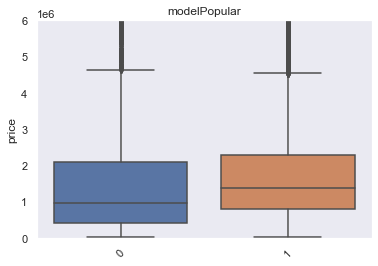

In [177]:
plot_cat_col_vs_price(data_train, 'modelPopular', [0, 6e6])

In [178]:
cols_to_del_test.append('model_name')
cols_to_del_test.append('model_info')
cols_to_del_train.append('model')
bin_cols.append('modelPopular')

# Vendor

In [179]:
data_test['vendor'].unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

Попробуем создать словарь из vendor и brand и по нему создать признак vendor в train.

In [180]:
# Создаем словарь из вендоров по брендам
vendor_dict = data_test.groupby(['vendor'])['brand'].apply(
    lambda grp: list(grp.value_counts().index)).to_dict()
vendor_dict

{'EUROPEAN': ['bmw', 'volkswagen', 'mercedes', 'audi', 'skoda', 'volvo'],
 'JAPANESE': ['nissan', 'toyota', 'mitsubishi', 'honda', 'infiniti', 'lexus']}

In [181]:
dif_list_brands = list(
    set(data_train.brand.unique()).difference(data_test.brand.unique()))
print("Список брендов, которых нет в test, но есть в train:", dif_list_brands)

Список брендов, которых нет в test, но есть в train: []


In [182]:
# Создадим новый словарь для мапинга
new_map = {str(x): str(k) for k, v in vendor_dict.items() for x in v}

In [183]:
# Создаем признак vendor в train
data_train['vendor'] = data_train.brand.copy()
data_train['vendor'] = data_train['vendor'].map(new_map)

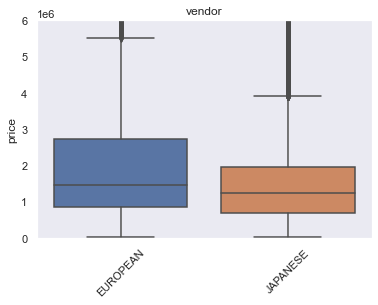

In [184]:
plot_cat_col_vs_price(data_train, 'vendor', [0, 6e6])

In [185]:
cols_to_oh_encode.append('vendor')

# Description

In [186]:
data_test['description'][5]

'Продаю свой автомобиль! Автомобиль полностью исправен и обслужен. Состояние авто отличное. Имеется зимняя резина,новая (отъездил на ней пару месяцев).Автомобиль очень бодрый и динамичный.Прошивку не делал. Все вопросы по телефону! Оригинальный ПТС. Установлен Даунпайп. Установлен Умный отопитель.Кузов в родной краске. Полный комплект ключей и документов. Обмен не интересует.'

Я удалю этот признак, но как идея на будущее - покапаться в описании и возможно можно достать новые признаки из него. 

In [187]:
cols_to_del_test.append('description')

# VehicleConfiguration

In [188]:
data_test['vehicleConfiguration'][5]

'LIFTBACK ROBOT 2.0'

vehicleConfiguration - дублирует информацию из колонок vehicleTransmission, engineDisplacement, bodyType. Удаляю

In [189]:
cols_to_del_test.append('vehicleConfiguration')

# Super_gen

In [190]:
data_test['super_gen'][5]

'{"id":"5009158","displacement":1984,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":200,"power_kvt":147,"human_name":"2.0 AMT (200 л.с.)","acceleration":7.2,"clearance_min":127,"fuel_rate":7.7}'

In [191]:
import ast

data_test['super_gen'] = data_test['super_gen'].apply(
    lambda x: ast.literal_eval(x))

In [192]:
data_test['super_gen'][5]['fuel_rate']

7.7

In [193]:
data_test['fuel_rate']=data_test['super_gen'].copy()

In [194]:
for i in range(0, len(data_test)):
    data_test['fuel_rate'][i] = data_test['super_gen'][i].get('fuel_rate')

<AxesSubplot:>

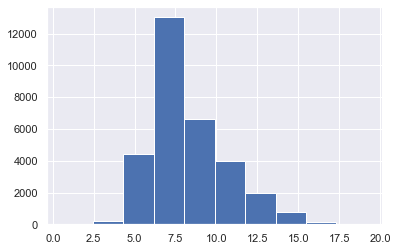

In [195]:
data_test['fuel_rate'].hist()

Похоже, что таких данные нет в train. Как идея на будущее - поискать дополнительные данные по модели автомобиля. Пока что удаляем. признак. 

In [196]:
cols_to_del_test.append('super_gen')
cols_to_del_test.append('fuel_rate')

# PriceCurrency

In [197]:
data_test['priceCurrency'].unique()

array(['RUB'], dtype=object)

Все цены в рублях. Удалим признак

In [198]:
cols_to_del_test.append('priceCurrency')

# Двигатель, Запас хода	, Комплектация, Налог и Гарантия

Удаляем э ти признаки, так как нет полезности в них в итоге на данный момент. Идея на будущее - поискать эти данные в описании

In [199]:
cols_to_del_train.append('Двигатель')
cols_to_del_train.append('Запас хода')
cols_to_del_train.append('Комплектация')
cols_to_del_train.append('Налог')
cols_to_del_train.append('Гарантия')

# Удаляем ненужные колонки

In [200]:
data_train.drop(cols_to_del_train, axis=1, inplace=True)

In [201]:
data_test.drop(cols_to_del_test, axis=1, inplace=True)

# Обработка пропусков

In [202]:
data_train.isnull().sum()

price                   0
numberOfDoors          10
productionDate          0
mileage                 0
bodyType                0
vehicleTransmission     0
Привод                  0
Руль                    0
Владельцы               0
ПТС                     0
fuelType                0
enginePower             0
engineDisplacement      0
brand                   0
modelDate              10
parsing_date            0
usd_currency            0
price_usd               0
carAge                  0
expensive_bodyType      0
popular_color           0
modelAge               10
km_per_year             0
expensive_brand         0
modelPopular            0
vendor                  0
dtype: int64

Пропусков немного, можем себе позволить удалить строки с пропусками

In [203]:
data_train.dropna(subset=['numberOfDoors'], inplace=True)
data_train.dropna(subset=['modelDate'], inplace=True)

# Обработка выбросов

In [204]:
num_cols

['price',
 'carAge',
 'productionDate',
 'modelDate',
 'modelAge',
 'mileage',
 'km_per_year',
 'engineDisplacement',
 'enginePower']

In [205]:
outliers(data_train['price'])

(2588, -1570500.0, 4617500.0)

In [206]:
print(data_train.loc[data_train['price'] > 4617500.0].modelDate.unique())

<IntegerArray>
[2019, 2018, 2017, 2020, 2015, 2014, 1958, 2008, 2013, 2016, 2021, 2012, 1999,
 1937, 2004, 2011, 1957, 2010, 2003, 1990, 1998, 1955, 2007, 1978]
Length: 24, dtype: Int64


В основном это или новые или очень старые (раритетные) машины. Что похоже на правду, поэтому не удаляем выбросы

In [207]:
outliers(data_train['mileage'])

(804, -110472.5, 370283.5)

In [208]:
print(data_train.loc[data_train['mileage'] > 370283.5].modelDate.unique())

<IntegerArray>
[2000, 2013, 2008, 2004, 1993, 1987, 1991, 1995, 2002, 1997, 1999, 2007, 2003,
 2005, 2011, 2001, 1994, 1998, 2006, 1996, 1988, 1989, 1985, 1992, 1983, 1990,
 1974, 1982, 2012, 1986, 1981, 1977, 2014, 2010, 1984, 2009, 2019, 1975, 1978,
 1976]
Length: 40, dtype: Int64


Правктически все очень старые машины, для которых пробег большой - оставляем. 

In [209]:
outliers(data_train['engineDisplacement'])

(1117, -0.49999999999999956, 5.1)

In [210]:
print(data_train.loc[data_train['engineDisplacement'] > 5.1].brand.unique())

['nissan' 'infiniti' 'mercedes' 'toyota' 'lexus' 'bmw' 'audi']


In [211]:
data_train['engineDisplacement'].max()

6.6

In [212]:
outliers(data_train['enginePower'])

(1378, -17.0, 391.0)

In [213]:
print(data_train.loc[data_train['enginePower'] > 391.0].brand.unique())

['bmw' 'nissan' 'infiniti' 'mercedes' 'lexus' 'volvo' 'toyota' 'audi']


Одни и те же бренды в выбросах. А так как объем двигателя и его мощность связаны, риску предположить что эти выбросы обоснованы. Оставляем

In [214]:
outliers(data_train['km_per_year'])

(1784, -2575.4166666666642, 35323.027777777774)

In [215]:
print(data_train.loc[data_train['km_per_year'] > 35323.027777777774].modelDate.unique())

<IntegerArray>
[2017, 2020, 2012, 2015, 2016, 2013, 2019, 2010, 2008, 2018, 2014, 2005, 2011,
 1995, 2009, 1989, 2003, 2006, 2007, 1998]
Length: 20, dtype: Int64


Большая часть - машины старые, а молодые поэтому и продаются, что пробег сделали большой. Оставляем

In [216]:
outliers(data_train['modelAge'])

(382, -2.0, 6.0)

In [217]:
data_train['modelAge'].value_counts()

 1     11748
 2     10219
 3      7181
 0      5002
 4      3755
 5      1540
 6       463
 7       172
 8        89
 9        36
 10       28
 11       16
 13       14
 12       12
 14        7
 18        6
-2         6
 17        1
-1         1
 16        1
Name: modelAge, dtype: Int64

In [219]:
cols_to_oh_encode
#cols_to_lab_encode
#num_cols

['Владельцы',
 'Руль',
 'numberOfDoors',
 'Привод',
 'vehicleTransmission',
 'ПТС',
 'vendor']

In [ ]:
# Находим median по price в трейне и размечаем валидацию
y_pred = tmp_val['mileage'].apply(lambda x: tmp_train['price'].median())
#оцениваем точность 
print_mape(mape(np.exp(y_val), np.exp(y_pred.values)))

# Корреляция признаков

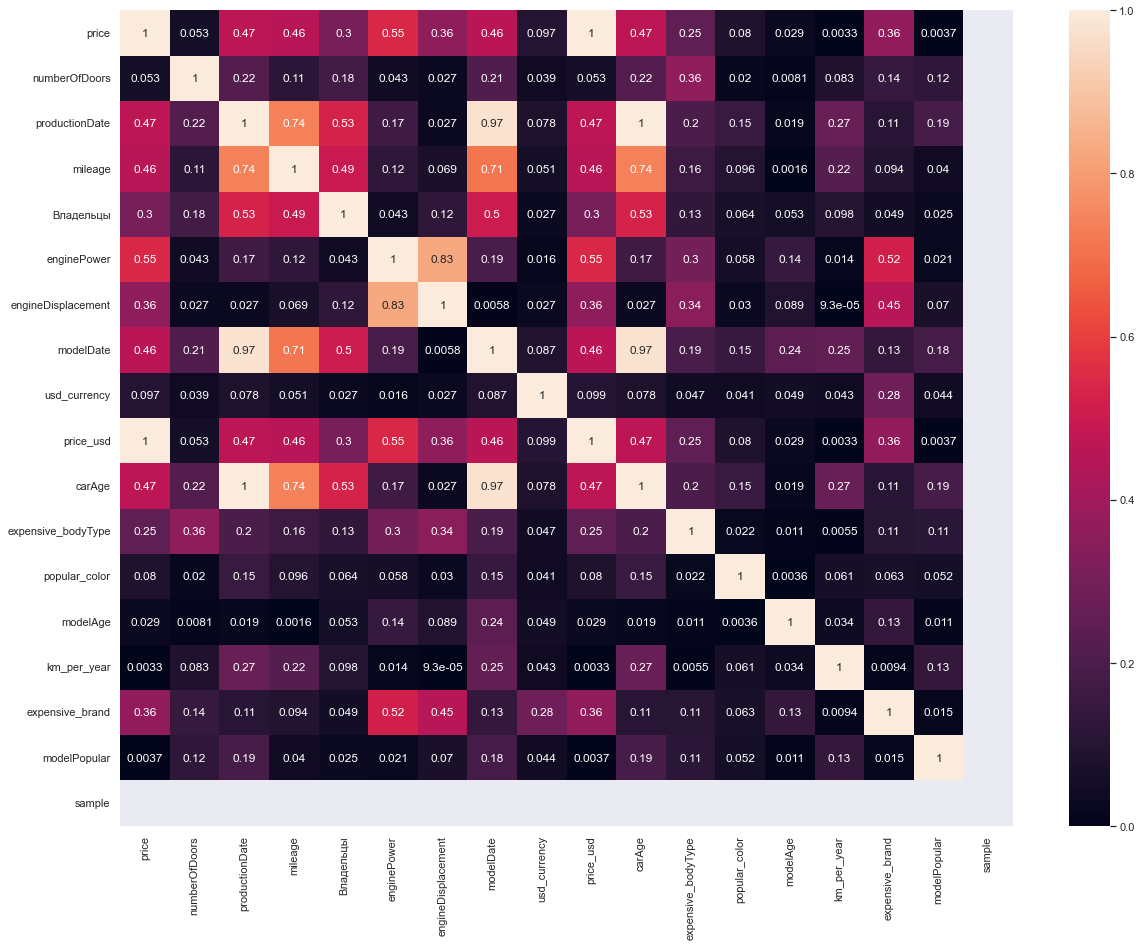

In [329]:
plt.figure(figsize=(20, 15))
sns.heatmap(data_train.corr().abs(), vmin=0, vmax=1, annot=True, fmt ='.2g')
plt.show()
#sns.heatmap(data_train[num_cols+bin_cols].corr().abs())

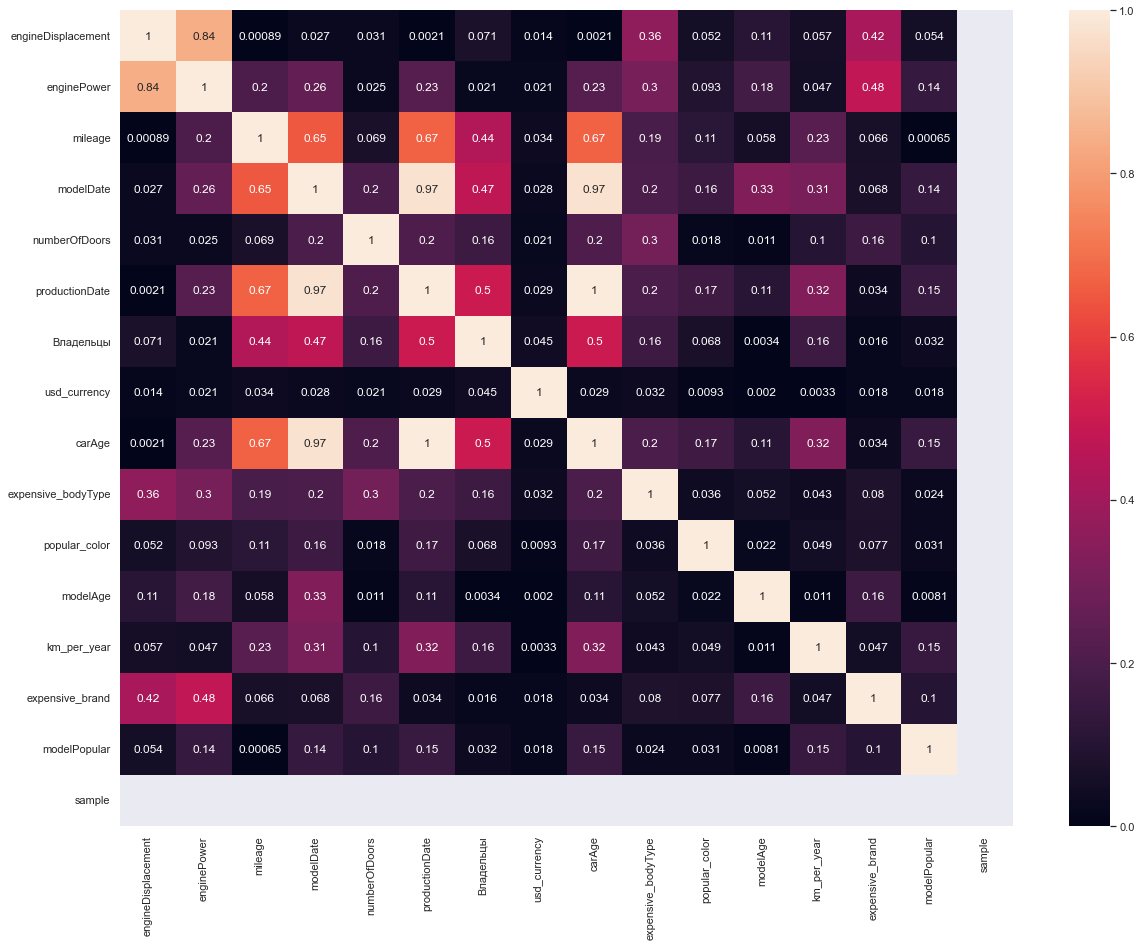

In [330]:
plt.figure(figsize=(20, 15))
sns.heatmap(data_test.corr().abs(), vmin=0, vmax=1, annot=True, fmt ='.2g')
plt.show()
#sns.heatmap(data_test[num_cols[1:]+bin_cols].corr().abs())

Объединим трейн и тест в один датасет для удобства дальнейшей работы

In [224]:
data_train['sample'] = 1
data_test['sample'] = 0
full_set = pd.concat([data_train, data_test], ignore_index=True)

In [225]:
full_set

,price,numberOfDoors,productionDate,mileage,bodyType,vehicleTransmission,Привод,Руль,Владельцы,ПТС,...,price_usd,carAge,expensive_bodyType,popular_color,modelAge,km_per_year,expensive_brand,modelPopular,vendor,sample
0,2400000,5,2019,20000,внедорожник,роботизированная,передний,Левый,1,Оригинал,...,32445.586048,2,1,1,3,10000.000000,0,1,EUROPEAN,1
1,1525000,5,2020,18890,лифтбек,автоматическая,передний,Левый,1,Оригинал,...,20616.466135,1,0,1,0,18890.000000,0,1,EUROPEAN,1
2,1450000,5,2012,119730,универсал,роботизированная,передний,Левый,1,Оригинал,...,19602.541571,9,0,0,4,13303.333333,0,1,EUROPEAN,1
3,690000,5,2011,210000,лифтбек,автоматическая,передний,Левый,3,Дубликат,...,9328.105989,10,0,1,3,21000.000000,0,1,EUROPEAN,1
4,215000,5,2000,183800,лифтбек,механическая,передний,Левый,3,Дубликат,...,2906.58375,21,0,0,0,8752.380952,0,1,EUROPEAN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74978,<NA>,4,2014,115000,седан,автоматическая,задний,Левый,3,Оригинал,...,<NA>,6,0,1,3,19166.666667,1,1,EUROPEAN,0
74979,<NA>,4,2018,98000,седан,автоматическая,полный,Левый,1,Оригинал,...,<NA>,2,0,1,2,49000.000000,1,1,EUROPEAN,0
74980,<NA>,4,1997,360000,седан,автоматическая,задний,Левый,3,Дубликат,...,<NA>,23,0,1,2,15652.173913,1,1,EUROPEAN,0
74981,<NA>,5,2013,90500,внедорожник,автоматическая,полный,Левый,2,Оригинал,...,<NA>,7,1,1,1,12928.571429,1,1,EUROPEAN,0


In [226]:
set_to_boost = full_set.drop(['parsing_date', 'usd_currency', 'price_usd'], axis=1)

In [227]:
set_to_boost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74983 entries, 0 to 74982
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                40297 non-null  Int64  
 1   numberOfDoors        74983 non-null  Int64  
 2   productionDate       74983 non-null  int64  
 3   mileage              74983 non-null  int64  
 4   bodyType             74983 non-null  object 
 5   vehicleTransmission  74983 non-null  object 
 6   Привод               74983 non-null  object 
 7   Руль                 74983 non-null  object 
 8   Владельцы            74983 non-null  Int64  
 9   ПТС                  74983 non-null  object 
 10  fuelType             74983 non-null  object 
 11  enginePower          74983 non-null  int64  
 12  engineDisplacement   74983 non-null  float64
 13  brand                74983 non-null  object 
 14  modelDate            74983 non-null  Int64  
 15  carAge               74983 non-null 

In [228]:
X_train = set_to_boost[set_to_boost['sample']==1].drop(['price'], axis=1)
X_test = set_to_boost[set_to_boost['sample']==0].drop(['price'], axis=1)
y = set_to_boost[set_to_boost['sample']==1]['price']

# Наивная модель

In [335]:
# Находим median по price в трейне и размечаем валидацию
y_pred = X_train['mileage'].apply(lambda x: full_set['price'].median())
#оцениваем точность 
mape(y, y_pred.values)

1.1021916851636102

Ошибка 110%, есть от чего оттолкнуться

# CatBoost

Определим колонки с категориальными признаками для catboost

In [229]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40297 entries, 0 to 40296
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   numberOfDoors        40297 non-null  Int64  
 1   productionDate       40297 non-null  int64  
 2   mileage              40297 non-null  int64  
 3   bodyType             40297 non-null  object 
 4   vehicleTransmission  40297 non-null  object 
 5   Привод               40297 non-null  object 
 6   Руль                 40297 non-null  object 
 7   Владельцы            40297 non-null  Int64  
 8   ПТС                  40297 non-null  object 
 9   fuelType             40297 non-null  object 
 10  enginePower          40297 non-null  int64  
 11  engineDisplacement   40297 non-null  float64
 12  brand                40297 non-null  object 
 13  modelDate            40297 non-null  Int64  
 14  carAge               40297 non-null  int64  
 15  expensive_bodyType   40297 non-null 

In [230]:
cat_features = np.array([0, 3, 4, 5, 6, 8, 9, 12, 15, 16, 19, 20, 21])

In [231]:
X_tr, X_te, y_tr, y_te = train_test_split(X_train.drop(['sample'], axis=1), y, test_size=0.2, random_state=42)

Построим и обучим модель задав параметры интуитивно.

In [294]:
model = CatBoostRegressor(iterations=5000, random_seed=42, learning_rate = 0.1, one_hot_max_size=3, eval_metric='MAPE', 
                          custom_metric=['R2', 'MAE'], thread_count=-1, od_type='Iter', od_wait=100, rsm=0.5)
pool = Pool(X_tr.values, label = np.log(y_tr), cat_features = cat_features)
pool_ev = Pool(X_te.values, label = np.log(y_te), cat_features = cat_features)

model.fit(pool, eval_set = pool_ev, verbose_eval=False, use_best_model=True,
         plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [295]:
predict = np.exp(model.predict(X_te.values))
print(f"Точность модели по метрике MAPE: {(mape(y_te, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 11.63%


На тренировочном датасете, с моделью с интуитивными параметрами, получили значение метрики 11.6%, лучше чем в бейзлайне. Теперь можно попробовать подобрать гиперпараметры с помощью gridsearch

In [296]:
model.get_params()

{'iterations': 5000,
 'learning_rate': 0.1,
 'rsm': 0.5,
 'loss_function': 'RMSE',
 'od_wait': 100,
 'od_type': 'Iter',
 'random_seed': 42,
 'one_hot_max_size': 3,
 'custom_metric': ['R2', 'MAE'],
 'eval_metric': 'MAPE'}

In [297]:
model.tree_count_

4975

In [298]:
pd.Series(data = model.feature_importances_, index= X_tr.columns).sort_values(ascending=False)

productionDate         20.519079
enginePower            15.461850
carAge                 13.471338
modelDate              12.001348
engineDisplacement      7.847638
mileage                 6.865881
brand                   3.455509
Привод                  3.266260
expensive_bodyType      3.220206
expensive_brand         3.060885
fuelType                1.943449
km_per_year             1.830933
bodyType                1.806068
vehicleTransmission     1.354376
vendor                  1.192538
numberOfDoors           0.768127
Владельцы               0.577902
modelAge                0.547374
Руль                    0.276945
modelPopular            0.220272
ПТС                     0.187266
popular_color           0.124758
dtype: float64

Совсем не важных признаков не обнаружено, так что удалять ничего не будем

In [ ]:
# Подбор гиперпараметров с помощью grid_search от CatBoost

grid = {'iterations': [6000], 'learning_rate': [0.05,0.1,0.3,0.5], 
              'one_hot_max_size': [0,3,4], 'l2_leaf_reg': [0.5,1,3], 'depth': [4, 6, 10]}


model = CatBoostRegressor(eval_metric = 'MAPE', thread_count=-1, cat_features=cat_features, random_seed=42, rsm=0.5)
grid_search_result = model.grid_search(grid, 
                                       X = X_train.drop(['sample'], axis=1).values, y = np.log(y), 
                                       partition_random_seed=42, verbose=200, 
                                       plot=True)

In [ ]:
grid_search_result['params']
#{'depth': 10,
#'one_hot_max_size': 0,
# 'iterations': 6000,
# 'learning_rate': 0.05,
# 'l2_leaf_reg': 0.5}

Теперь на основе лучших параметров обучим модель на всем трейне и проверим качество сабмитом. Также отнимем 1 от года производства автомобиля в трейновом датасете, чтобы модель корректно оценивала тестовый (собраный на год раньше). По той же причине цену в тренировочном датасете уменьшим на 25% (коэф. уменьшения получен с 3-го раза опытным путем)

In [232]:
X_train['productionDate'] = X_train['productionDate'] - 1
X_train.drop(['sample'], axis=1, inplace=True)

In [ ]:
model_best = CatBoostRegressor(iterations = 6500, random_seed=42, learning_rate = 0.05, one_hot_max_size=0,
                               eval_metric='MAPE', custom_metric=['R2', 'MAE'], thread_count=-1, depth = 10,
                               l2_leaf_reg = 0.5, rsm=0.5)
pool_sub = Pool(X_train.values, label = np.log(y*0.75), cat_features = cat_features)
#pool_ev = Pool(X_te.values, label = np.log(y_te), cat_features = cat_features)

model_best.fit(pool_sub, verbose=300,
         plot=True)

In [ ]:
submission_predict = np.exp(model_best.predict(X_test.drop(['sample'], axis=1).values))

In [ ]:
submission_to_kaggle = pd.read_csv(dir_test+'sample_submission.csv')
submission_to_kaggle['price'] = submission_predict

In [ ]:
submission_to_kaggle.to_csv('submit3.csv', index=False)

Ошибка на кагл составила 15.3%. Неплохо, переходим к следующему этапу.

Далее построим другие модели для проведения стекинга

# Стандартизация

Для catboost стандартизация и энкодинг признаков не были важны, но для большинства других моделей лучше предварительно стандартизировать признаки.

In [233]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import make_scorer

Признак 'fuelType' имеет 5 значений, думаю это не слишком много для one-hot кодирования, но должно повысить качество предсказаний. Переместим его в список признаков для one-hot encoding

In [276]:
cols_to_oh_encode.append('fuelType')
cols_to_lab_encode.remove('fuelType')

In [277]:
ohe = OneHotEncoder(sparse=False)
transformed = ohe.fit_transform(full_set[cols_to_oh_encode])
oh_part = pd.DataFrame(data = transformed, columns = ohe.get_feature_names(full_set[cols_to_oh_encode].columns))

In [278]:
oe = OrdinalEncoder()
labeled = oe.fit_transform(full_set[cols_to_lab_encode])
lab_part = pd.DataFrame(data = labeled, columns = full_set[cols_to_lab_encode].columns)

In [279]:
std = StandardScaler()
standarted = std.fit_transform(full_set[num_cols[1:]])
num_part = pd.DataFrame(data = standarted, columns = full_set[num_cols[1:]].columns)

In [280]:
# Собираем в один датасет все стандартизированные и кодированные признаки

full_encoded_set = pd.concat([num_part, lab_part, oh_part, full_set[bin_cols], full_set[['sample']]], axis=1)

In [281]:
X_train_encoded = full_encoded_set[full_encoded_set['sample']==1].drop(['sample'], axis=1)
X_test_encoded = full_encoded_set[full_encoded_set['sample']==0].drop(['sample'], axis=1)

# Подготовка моделей для стекинга

Подбор гиперпараметров для следующих моделей был осуществлен, коллегой по команде. Так что будут сразу обучены модели с подобраными гиперпараметрами.

In [282]:
X_tr_enc, X_te_enc, y_tr_enc, y_te_enc = train_test_split(X_train_encoded, y, test_size=0.2, random_state=42)

In [283]:
xgb = XGBRegressor(learning_rate = 0.1, max_depth = 7, n_estimators = 1000)
xgb.fit(X_tr_enc, np.log(y_tr_enc))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [284]:
mape(y_te_enc, np.exp(xgb.predict(X_te_enc)))

0.11578822725603322

XGBRegressor дал ошибку 11.6%, для стекинга вполне подходит

In [285]:
lgbm = LGBMRegressor(learning_rate = 0.1, max_depth = 7, n_estimators = 1000)
lgbm.fit(X_tr_enc.values, np.log(y_tr_enc))

LGBMRegressor(max_depth=7, n_estimators=1000)

In [286]:
mape(y_te_enc, np.exp(lgbm.predict(X_te_enc.values)))

0.12060038405364691

LGBM дает ошибку 12.1%, тоже оставим для стекинга

In [287]:
rf = RandomForestRegressor(criterion = 'mse', min_samples_leaf = 10, n_estimators = 250, n_jobs=-1, random_state=42)
rf.fit(X_tr_enc.values, np.log(y_tr_enc))

RandomForestRegressor(min_samples_leaf=10, n_estimators=250, n_jobs=-1,
                      random_state=42)

In [288]:
mape(y_te_enc, np.exp(rf.predict(X_te_enc.values)))

0.12982270320552547

Random Forest сработал хуже всех: 12.9%, но для стекинга может и пригодится

# Стекинг

В стекинге мета-моделью будет линейная регрессия. Мета-признаки для построения мета-модели посчитаем с помощью функций. Для XGBRegressor, LGBMRegressor и RandomForest метрики посчитаем через функцию "generate_metafeatures". Для CatBoost посчитаем отдельно через "compute_meta_feature", т.к. будем использовать разбиение на меньшее кол-во фолдов(3 вместо 5), для уменьшения временных затрат.

In [299]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the model.
    
    :arg model: model to compute features
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_model = clone(model)
        folded_model.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
    
    meta_model = clone(model)
    meta_model.fit(X_train, y_train)
    
    X_meta_test = meta_model.predict(X_test)
    
    return X_meta_train, X_meta_test

def generate_meta_features(models, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of models.
    
    :arg classifiers: list of models
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(model, X_train, X_test, y_train, cv)
        for model in tqdm(models)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [300]:
cv5 = KFold(n_splits=5, shuffle=True) 
cv3 = KFold(n_splits=3, shuffle=True) #для CatBoost

In [301]:
models = [XGBRegressor(learning_rate = 0.1, max_depth = 7, n_estimators = 1000), 
               LGBMRegressor(learning_rate = 0.1, max_depth = 7, n_estimators = 1000),
               RandomForestRegressor(criterion = 'mse', min_samples_leaf = 10, n_estimators = 250, n_jobs=-1)]

In [302]:
from sklearn.base import clone

In [303]:
stacked_features_train, stacked_features_test = generate_meta_features(models, X_train_encoded.values, X_test_encoded.values, 
                                                                       np.log(y*0.75), cv5)

  0%|          | 0/3 [00:00<?, ?it/s]

In [307]:
model_stack = CatBoostRegressor(iterations = 6500, cat_features = cat_features, random_seed=42, learning_rate = 0.05, one_hot_max_size=0,
                               eval_metric='MAPE', thread_count=-1, depth = 10,
                               l2_leaf_reg = 0.5, verbose=500, rsm=0.5)
#pool_sub = Pool(X_train.values, label = np.log(y*0.75), cat_features = cat_features)

In [308]:
X_meta_train, X_meta_test = compute_meta_feature(model_stack, X_train.values, X_test.values, np.log(y*0.75), cv3)

0:	learn: 0.0492825	total: 150ms	remaining: 16m 15s
500:	learn: 0.0070824	total: 1m 24s	remaining: 16m 51s
1000:	learn: 0.0057683	total: 2m 47s	remaining: 15m 21s
1500:	learn: 0.0049396	total: 4m 17s	remaining: 14m 17s
2000:	learn: 0.0043346	total: 5m 43s	remaining: 12m 51s
2500:	learn: 0.0038799	total: 7m 9s	remaining: 11m 27s
3000:	learn: 0.0035008	total: 8m 35s	remaining: 10m
3500:	learn: 0.0031912	total: 10m 1s	remaining: 8m 34s
4000:	learn: 0.0029259	total: 11m 28s	remaining: 7m 10s
4500:	learn: 0.0027026	total: 12m 54s	remaining: 5m 44s
5000:	learn: 0.0024959	total: 14m 22s	remaining: 4m 18s
5500:	learn: 0.0023083	total: 15m 47s	remaining: 2m 51s
6000:	learn: 0.0021476	total: 17m 12s	remaining: 1m 25s
6499:	learn: 0.0020010	total: 18m 37s	remaining: 0us
0:	learn: 0.0495034	total: 151ms	remaining: 16m 18s
500:	learn: 0.0070856	total: 1m 19s	remaining: 15m 48s
1000:	learn: 0.0057864	total: 2m 39s	remaining: 14m 37s
1500:	learn: 0.0049857	total: 4m 1s	remaining: 13m 23s
2000:	learn:

In [309]:
stacked_features_train = np.hstack([stacked_features_train, X_meta_train.reshape(-1,1)])
stacked_features_test = np.hstack([stacked_features_test, X_meta_test.reshape(-1,1)])

In [310]:
rgs = LinearRegression()
rgs.fit(stacked_features_train, np.log(y*0.75))
predict_stack = rgs.predict(stacked_features_test)

In [311]:
# for kaggle
#submission_to_kaggle = pd.read_csv(dir_test+'sample_submission.csv')

submission_to_kaggle = pd.read_csv(r'C:\Users\User\projects\Skillfactory\module_6\sample_submission_auto.csv')
submission_to_kaggle['price'] = np.exp(predict_stack)

In [312]:
submission_to_kaggle.to_csv('submit_stack3.csv', index=False)

На кагл ошибка составила 15.14%

В итоге, благодаря стекингу результат по сравнению с катбустом улучшился примерно на 0.16%

<a href="Your file path"> Download File </a>